# Доставка товаров - 2 А/В теста

Есть приложение по доставке готовых продуктов. Есть результаты двух тестов:

1. В первом тестировали разрешение фотографий блюд в приложении: пользователям показывались либо прямоугольные, либо новые квадратные 
2. Во втором: была обновлена кнопка заказа, и часть юзеров видела старый вариант, а часть – новый.

Нужно проверить гипотезы, сделать соответствующие выводы на основе статистических тестов и принять решения.

<b>Задачи</b>

1. Выбрать метод, который предположительно подойдет в первом вопросе.
2. Проверить, являются ли дисперсии внутри групп гомогенными.
3. Провести тест на нормальность распределения.
4. Сравнить средние в представленных группах.
5. Используя критерий Тьюки, определить, между какими группами есть статистически значимые различия. 
6. Принять решение: какие картинки в итоге будем использовать?
7. Выбрать метод для второго теста.
8. Визуализировать распределение events для контрольной и тестовой групп. 
9. Посмотреть на описательные статистики events в разбивке по группе и по сегменту пользователя. 
10. Выбрать формулу для модели, провести тест.

<b>Описание данных</b>

Датасет с результатами первого теста:

- id – id клиента в эксперименте
- group – в каком разрешении показывались картинки (A – прямоугольные 16:9, B – квадратные, C – прямоугольные 12:4)
- events – сколько блюд суммарно было заказано за период

Датасет с результатами второго теста:

- id – id клиента в эксперименте
- segment – сегмент (high/low)
- group – вид кнопки (control – старая версия, test – новая версия)
- events – сколько блюд суммарно было заказано за период

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as ss
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.api import anova_lm
from statsmodels.stats.multicomp import (pairwise_tukeyhsd, MultiComparison)

import pingouin as pg
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# устанавливаем размер графиков
sns.set(rc={'figure.figsize':(12,6)})

In [33]:
data1 = pd.read_csv('5_task_1.csv')
data2 = pd.read_csv('5_task_2.csv')

## Первый эксперимент с изображениями

Для проведения первого эксперимента использовались три вида фотографий: 
- A – прямоугольные 16:9
- B – квадратные
- C – прямоугольные 12:4

Так как есть 3 варианта и нам нужен метод, дающий показатели статистической значимости, будем использовать ANOVA (дисперсионный анализ).

In [4]:
data1.head()

,id,group,events
0,16046,A,14
1,18712,A,41
2,3268,A,30
3,22633,A,37
4,28071,A,38


In [5]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      30000 non-null  int64 
 1   group   30000 non-null  object
 2   events  30000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 703.2+ KB


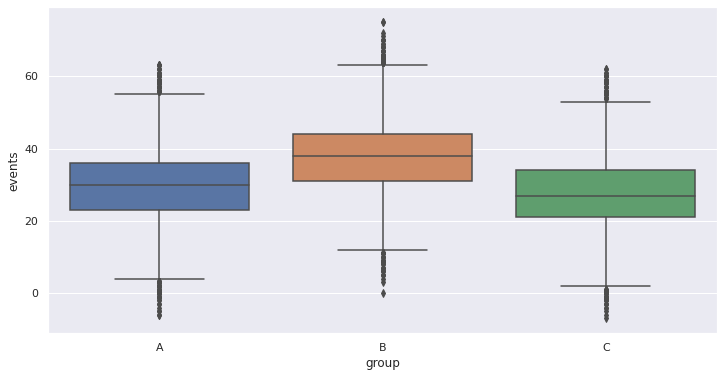

In [6]:
sns.boxplot(x='group', y='events', data=data1);

In [7]:
# создадим Серии для каждой группы
A = data1.query('group == "A"').events
B = data1.query('group == "B"').events
C_ = data1.query('group == "C"').events

In [8]:
# проверим, являются ли дисперсии внутри групп примерно одинаковыми (гомогенными) с помощью теста Левена
ss.levene(A, B, C_)

LeveneResult(statistic=2.2622596339318037, pvalue=0.1041327199523974)

In [9]:
# аналог теста
pg.homoscedasticity(data=data1, dv='events', group='group')

,W,pval,equal_var
levene,2.26226,0.104133,True


p-value = 0.104133 (> 0.05), не отклоняем нулевую гипотезу, значит дисперсии внутри групп примерно равны.

Убедимся, что данные распределены нормально с помощью метода normaltest библиотеки scipy и библиотеки pingouin.

In [10]:
# данные все распределены нормально (p-value > 0.05)
print(ss.normaltest(A))
print(ss.normaltest(B))
print(ss.normaltest(C_))

NormaltestResult(statistic=2.1034599402238734, pvalue=0.3493328906085719)
NormaltestResult(statistic=0.8410715800223014, pvalue=0.6566948749848232)
NormaltestResult(statistic=3.243725809054571, pvalue=0.19753037588314626)


In [11]:
# через pingouin
pg.normality(data=data1, dv='events', group='group', method='normaltest')

,W,pval,normal
A,2.103460,0.349333,True
B,0.841072,0.656695,True
C,3.243726,0.197530,True


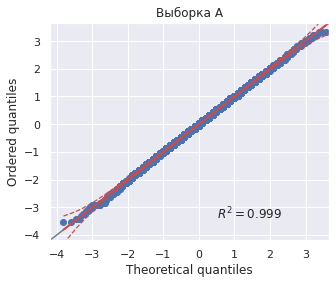

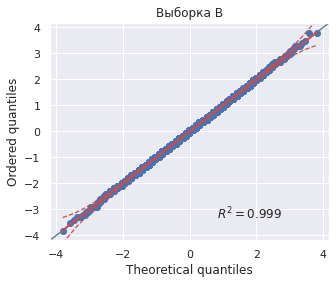

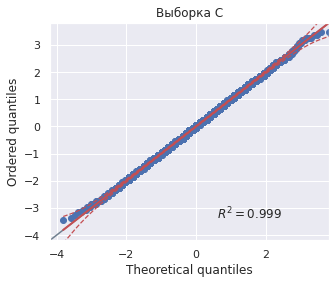

In [12]:
# построим квантиль-квантиль графики
pg.qqplot(A)
plt.title('Выборка A')
pg.qqplot(B)
plt.title('Выборка B')
pg.qqplot(C_)
plt.title('Выборка C');

Все выборки распределены нормально. Проведем тест. Для сравнения средних используем однофакторный дисперсионный анализ.

In [13]:
# способ scipy - однофакторный дисперсионный анализ, p-value < 0.05, отклоняем H0, средние различимы в группах
ss.f_oneway(A, B, C_)

F_onewayResult(statistic=2886.166657438961, pvalue=0.0)

In [14]:
# способ pingouin
pg.anova(data=data1, dv='events', between='group')

,Source,ddof1,ddof2,F,p-unc,np2
0,group,2,29997,2886.166657,0.0,0.161377


Значение F-статистики примерно равно 2886, а p-уровень значимости составил 0.

Теперь используем критерий Тьюки, поправки Бонферрони и Гейсм-Хоувелла и определим, между какими группами есть статистически значимые различия.

In [15]:
# statsmodel
pairwise_tukeyhsd(data1.events, data1.group).summary()

group1,group2,meandiff,p-adj,lower,upper,reject
A,B,8.034,0.001,7.7038,8.3642,True
A,C,-2.1093,0.001,-2.4395,-1.7791,True
B,C,-10.1433,0.001,-10.4735,-9.8131,True


In [16]:
# pingouin
pg.pairwise_tukey(data=data1, dv='events', between='group')

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,A,B,29.5796,37.6136,-8.0340,0.140894,-57.021604,0.001,-0.806377
1,A,C,29.5796,27.4703,2.1093,0.140894,14.970833,0.001,0.211712
2,B,C,37.6136,27.4703,10.1433,0.140894,71.992436,0.001,1.018089


In [17]:
# с поправкой Бонферрони
pg.pairwise_ttests(data=data1, dv='events', between='group', padjust='bonf')

/opt/tljh/user/lib/python3.7/site-packages/pingouin/bayesian.py:146: RuntimeWarning: divide by zero encountered in double_scalars
  bf10 = 1 / ((1 + t**2 / df)**(-(df + 1) / 2) / integr)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,group,A,B,False,True,-57.011134,19998.0,two-sided,0.000000e+00,0.000000e+00,bonf,inf,-0.806229
1,group,A,C,False,True,14.886135,19998.0,two-sided,7.500262e-50,2.250078e-49,bonf,1.054e+46,0.210514
2,group,B,C,False,True,72.420220,19998.0,two-sided,0.000000e+00,0.000000e+00,bonf,inf,1.024138


In [18]:
# гейсм-хоувелл
pg.pairwise_gameshowell(data=data1, dv='events', between='group')

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,A,B,29.5796,37.6136,-8.0340,0.140920,-57.011134,19987.258491,0.001,-0.806229
1,A,C,29.5796,27.4703,2.1093,0.141696,14.886135,19995.116233,0.001,0.210514
2,B,C,37.6136,27.4703,10.1433,0.140062,72.420220,19995.502469,0.001,1.024138


### Вывод по первому эксперименту

Все три теста показали, что нулевая гипотеза отвергается (p-value < 0.05) - между всеми группами есть статистически значимые различия.

Столбец meandiff/diff отражает различие в средних между второй и первой группой. Все тесты показали, что самые большие различия получились между выборкой с квадратными изображениями (B):
- между А и В = 8
- между С и В = 10

Итого: дисперсии внутри групп примерно одинаковые, выборки нормально распределены, тесты показали значимые различия между выборками, значения в meandiff/diff самые большие оказались с группой B, выбираем вариант В (квадратные изображения).

## Второй эксперимент с форматом кнопки

Во втором эксперименте требуется проверить, как пользователи отреагируют на изменение формата кнопки оформления заказа, с разбивкой по сегменту клиента. Будем использовать метод многофакторного дисперсионного анализа.

In [19]:
data2.head()

,id,group,segment,events
0,83440,test,high,78.0
1,96723,test,high,71.0
2,68719,test,high,80.0
3,50399,test,high,80.0
4,95613,test,high,78.0


In [20]:
data2.group.unique()

array(['test', 'control'], dtype=object)

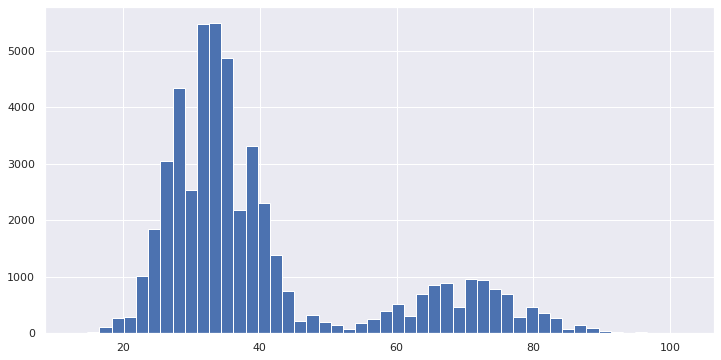

In [21]:
# распределение для тестовой группы
data2.query('group == "test"').events.hist(bins=50);

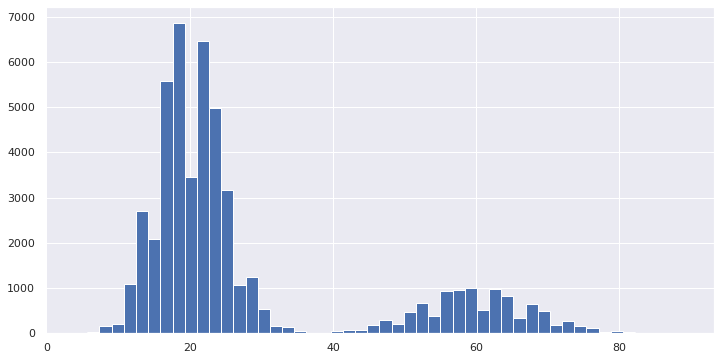

In [22]:
# распределение для контрольной группы
data2.query('group == "control"').events.hist(bins=50);

In [23]:
# найдем среднее, медиану и стандартное отклонение events в разбивке по группе и по сегменту пользователя 
data2.groupby(['group', 'segment']).events.describe()

count       mean       std   min   25%   50%   75%    max
group   segment                                                             
control high     10000.0  59.970800  7.805347  31.0  55.0  60.0  65.0   89.0
        low      40000.0  20.031575  4.473576   4.0  17.0  20.0  23.0   41.0
test    high     10000.0  69.938500  8.403974  40.0  64.0  70.0  76.0  102.0
        low      40000.0  33.025925  5.720845  13.0  29.0  33.0  37.0   59.0

Проверим эффект нескольких переменных – group и segment – на events, с взаимодействием факторов.

In [24]:
# через statsmodel
model = smf.ols("events ~ C(group) + C(segment) + C(group):C(segment)", data=data2).fit()
anova_lm(model, typ = 2)

,sum_sq,df,F,PR(>F)
C(group),3.837195e+06,1.0,112031.864119,0.000000e+00
C(segment),2.362480e+07,1.0,689756.377484,0.000000e+00
C(group):C(segment),3.664244e+04,1.0,1069.823273,2.060261e-233
Residual,3.424956e+06,99996.0,NaN,NaN


In [25]:
# через pingouin
pg.anova(data=data2, dv='events', between=['group', 'segment'])

,Source,SS,DF,MS,F,p-unc,np2
0,group,3.837195e+06,1.0,3.837195e+06,112031.864119,0.000000e+00,0.528383
1,segment,2.362480e+07,1.0,2.362480e+07,689756.377484,0.000000e+00,0.873383
2,group * segment,3.664244e+04,1.0,3.664244e+04,1069.823273,2.060261e-233,0.010585
3,Residual,3.424956e+06,99996.0,3.425093e+01,NaN,NaN,NaN


Оба фактора и их взаимосвязь оказались статистически значимыми: p-value < 0.05.

In [26]:
# соединим колонки group и segment в combination, чтобы потом передать новый столбец в аргумент groups
data2['combination'] = data2['group'] + ' \\ ' + data2['segment'] 

In [27]:
data2.head()

,id,group,segment,events,combination
0,83440,test,high,78.0,test \ high
1,96723,test,high,71.0,test \ high
2,68719,test,high,80.0,test \ high
3,50399,test,high,80.0,test \ high
4,95613,test,high,78.0,test \ high


Теперь используем критерий Тьюки и поправку Гейсм-Хоувелла и определим, между какими группами есть статистически значимые различия.

In [28]:
# statsmodel
pairwise_tukeyhsd(data2.events, data2.combination).summary()

group1,group2,meandiff,p-adj,lower,upper,reject
control \ high,control \ low,-39.9392,0.001,-40.1073,-39.7711,True
control \ high,test \ high,9.9677,0.001,9.7551,10.1803,True
control \ high,test \ low,-26.9449,0.001,-27.113,-26.7768,True
control \ low,test \ high,49.9069,0.001,49.7388,50.075,True
control \ low,test \ low,12.9944,0.001,12.888,13.1007,True
test \ high,test \ low,-36.9126,0.001,-37.0807,-36.7445,True


In [29]:
# тьюки
pg.pairwise_tukey(data=data2, dv='events', between='combination')

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,control \ high,control \ low,59.970800,20.031575,39.939225,0.065432,610.391461,0.001,6.824282
1,control \ high,test \ high,59.970800,69.938500,-9.967700,0.082766,-120.432523,0.001,-1.703109
2,control \ high,test \ low,59.970800,33.025925,26.944875,0.065432,411.798717,0.001,4.603981
3,control \ low,test \ high,20.031575,69.938500,-49.906925,0.065432,-762.727892,0.001,-8.527429
4,control \ low,test \ low,20.031575,33.025925,-12.994350,0.041383,-314.002699,0.001,-2.220314
5,test \ high,test \ low,69.938500,33.025925,36.912575,0.065432,564.135148,0.001,6.307128


In [30]:
# гейсм-хоувелл
pg.pairwise_gameshowell(data=data2, dv='events', between='combination')

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,control \ high,control \ low,59.970800,20.031575,39.939225,0.081195,491.891252,11689.025486,0.001,5.499429
1,control \ high,test \ high,59.970800,69.938500,-9.967700,0.114695,-86.905881,19889.784497,0.001,-1.228989
2,control \ high,test \ low,59.970800,33.025925,26.944875,0.083130,324.130575,12807.332699,0.001,3.623836
3,control \ low,test \ high,20.031575,69.938500,-49.906925,0.086966,-573.870317,11451.476175,0.001,-6.415969
4,control \ low,test \ low,20.031575,33.025925,-12.994350,0.036311,-357.857879,75603.667906,0.001,-2.530414
5,test \ high,test \ low,69.938500,33.025925,36.912575,0.088774,415.802398,12408.307593,0.001,4.648742


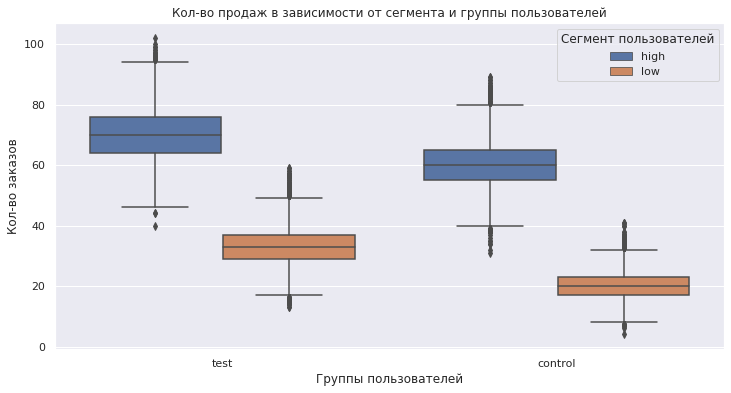

In [31]:
sns.boxplot(x = 'group', y = 'events', hue = 'segment', data = data2)
plt.title('Кол-во продаж в зависимости от сегмента и группы пользователей')
plt.xlabel('Группы пользователей')
plt.ylabel('Кол-во заказов')
plt.legend(title = 'Сегмент пользователей');

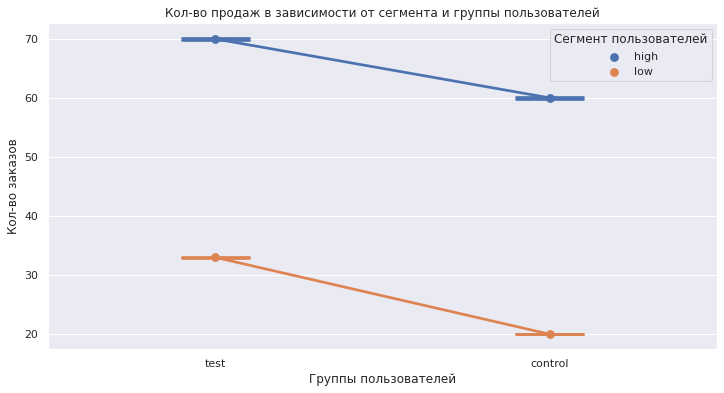

In [32]:
sns.pointplot(x = 'group', y = 'events', hue = 'segment', data = data2, capsize = .2)
plt.title('Кол-во продаж в зависимости от сегмента и группы пользователей')
plt.xlabel('Группы пользователей')
plt.ylabel('Кол-во заказов')
plt.legend(title = 'Сегмент пользователей');

Видим:
- разница между control/high и test/high составила около 10
- для обоих сегментов показатели статистически значимо увеличились по сравнению с контрольной группой
- разница между значением у тестовой группы сегмента low и контрольной группой этого же сегмента равна примерно 13

### Вывод по второму эксперименту

Факторы group и segment оказались статистически значимыми, как и их взаимодействие. Судя по графику и результатам тестов, для всех групп среднее значение events увеличилось, поэтому решение: внедряем новое решение с обновленным дизайном.

## Итоговый вывод

В ходе данного проекта было сделано:
- выбрали методы, которые подойдут для разных А/В тестов: однофакторный дисперсионный анализ и многофакторный дисперсионный анализ
- проверили дисперсии внутри групп на гомогенность
- сравнили средние в представленных группах
- используя критерии Тьюки, поправки Бонферрони и Гейсм-Хоувелла, определили, между какими группами есть статистически значимые различия
- визуализировали распределения кол-ва покупок для контрольной и тестовой групп
- посмотрели на описательные статистики в разбивке по группам и сегментам пользователей
- выбрали формулы для модели и провели тесты
- по результатам тестов нашли группы со статистически значимыми различиями
- приняли решения о внедрении новых изменений в приложении на основании результатов А/В тестов